# Generate GIF for a colocalization 
(to update with 41_coloc_images functions if needed)

In [17]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine


import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm as cmap
from matplotlib.cm import ScalarMappable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.130:8787/status,
Dashboard: http://10.148.0.130:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.130:58497,Workers: 0
Dashboard: http://10.148.0.130:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Import data and select one obs

In [6]:
def dataset_one_obs(nlabel, nobs, dt=(-31*24,33*24), dt_d = (-31,33)):
    #dataset
    label=labels[nlabel]
    do = xr.open_zarr(zarr_dir+'/'+label+'.zarr').isel(obs=nobs).persist()
    do_aviso = aviso.get_aviso_one_obs(do, dt=dt_d, only_matchup_time = False).drop(['drifter_x', 'drifter_y', 'drifter_time','time'])
    do_wind = eras.get_eras_one_obs(do, dt=dt, only_matchup_time = False).drop(['drifter_x', 'drifter_y', 'drifter_time', 'time'])
    do = xr.merge([do,do_wind, do_aviso], compat = 'override')
    list_wd_srce_suffix = ['es']
    list_func = [stw.cst_rio_z0]
    list_func_suffix = ['cstrio_z0']
    wd_term = stw.compute_wd_from_stress(do,list_wd_srce_suffix=list_wd_srce_suffix, list_func=list_func, list_func_suffix=list_func_suffix)
    do = xr.merge([do, wd_term]).set_coords(['aviso_time_','es_time_']).swap_dims({'site_obs':'drifter_time', 'es_time':'es_time_', 'aviso_time':'aviso_time_'}).persist()
    do = do.interp(aviso_time_ = do.drifter_time, es_time_ = do.drifter_time)
    return do

In [7]:
do = dataset_one_obs(0,509)
do

<xarray.Dataset>
Dimensions:                             (alti_time: 21, alti_time_mid: 20,
                                         box_y: 40, box_x: 80,
                                         drifter_time: 1489)
Coordinates: (12/21)
    alti_lat                            (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_lon                            (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                           (alti_time) int64 0 1 2 3 ... 18 19 20
    alti_time_                          (alti_time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * alti_time_mid                       (alti_time_mid) float64 0.5 1.5 ... 19.5
    alti_x                              (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    ...                                  ...
    lat                                 float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                                 float64 dask.array<chunksize=(), meta=np.ndarray>
    time                                datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    aviso_time_                         (drifter_time) datetime64[ns] 2017-12...
    es_time_                            (drifter_time) datetime64[ns] 2017-12...
  * drifter_time                        (drifter_time) datetime64[ns] 2017-12...
Data variables: (12/114)
    __site_id                           object dask.array<chunksize=(), meta=np.ndarray>
    __site_matchup_indice               int32 dask.array<chunksize=(), meta=np.ndarray>
    __site_name                         object dask.array<chunksize=(), meta=np.ndarray>
    alti___distance                     float64 dask.array<chunksize=(), meta=np.ndarray>
    alti___source                       object dask.array<chunksize=(), meta=np.ndarray>
    alti___source_center_index          object dask.array<chunksize=(), meta=np.ndarray>
    ...                                  ...
    es_cstrio_z0_drifter_wd_y           float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_traj_wd_x              (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_traj_wd_y              (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_box_wd_x               (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    es_cstrio_z0_box_wd_y               (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    drifter_typebuoy                    (drifter_time) object dask.array<chunksize=(94,), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [14]:
def clippedcolorbar(fig, CS, **kwargs):
    from matplotlib.cm import ScalarMappable
    from numpy import arange, floor, ceil
    vmin = CS.get_clim()[0]
    vmax = CS.get_clim()[1]
    m = ScalarMappable(cmap=CS.get_cmap())
    m.set_array(CS.get_array())
    m.set_clim(CS.get_clim())
    step = CS.levels[1] - CS.levels[0]
    cliplower = CS.zmin<vmin
    clipupper = CS.zmax>vmax
    noextend = 'extend' in kwargs.keys() and kwargs['extend']=='neither'
    # set the colorbar boundaries
    boundaries = arange((floor(vmin/step)-1+1*(cliplower and noextend))*step, (ceil(vmax/step)+1-1*(clipupper and noextend))*step, step)
    kwargs['boundaries'] = boundaries
    # if the z-values are outside the colorbar range, add extend marker(s)
    # This behavior can be disabled by providing extend='neither' to the function call
    if not('extend' in kwargs.keys()) or kwargs['extend'] in ['min','max']:
        extend_min = cliplower or ( 'extend' in kwargs.keys() and kwargs['extend']=='min' )
        extend_max = clipupper or ( 'extend' in kwargs.keys() and kwargs['extend']=='max' )
        if extend_min and extend_max:
            kwargs['extend'] = 'both'
        elif extend_min:
            kwargs['extend'] = 'min'
        elif extend_max:
            kwargs['extend'] = 'max'
    return fig.colorbar(m, **kwargs)

In [71]:
def coloc_image_t(fig, do, nlabel, nobs, it, scaleera=1):
    label=labels[nlabel]
    lon, lat, t = float(do.lon), float(do.lat), do.time.values
    id_matchup = int(do.__site_matchup_indice.values)
    td = pd.to_datetime(t)
    dt = float(do["alti___time_difference"])
    dl = float(do["alti___distance"])
    nb_drifter_time = do.dims['drifter_time']

    do_t = do.isel(drifter_time = it)
    t = pd.to_datetime(do_t.drifter_time.values)
    
    ax = fig.add_subplot(111, projection=ccrs.Orthographic(lon, lat))
    #ax.patch.set_facecolor('white')
    #ax.patch.set_alpha(1.0)
    land_feature = cfeature.LAND
    
    
    #AVISO
    #min_=abs(do_t["aviso_box_sla"].min())
    #max_=abs(do_t["aviso_box_sla"].max())
    #a=max(min_,max_)
    a=0.22
    C=ax.contourf(do_t.box_lon, do_t.box_lat, do_t.aviso_box_sla,  levels = np.arange(-a, a, 0.01), cmap='bwr',transform=crs, extend='both')
    #C=ax.pcolormesh(do_t.box_lon, do_t.box_lat, do_t.aviso_box_sla, vmin=-a, vmax=a, cmap='bwr',transform=crs)
    #ax.contour
    #fig.colorbar(C).remove()
    #colorbar = clippedcolorbar(fig, C)
    
    
    #ax.set_colorbar(ScalarMappable(norm=C.norm, cmap=C.cmap),)
    #fig.delaxes(fig.ax)
    
    #axes
    lonc, latc=do.box_lonc,do.box_latc
    ax_y=do.isel(drifter_time=it).sel(box_x=0, box_y=50000)[['box_lon', 'box_lat']].compute()
    ax_x=do.isel(drifter_time=it).sel(box_x=100000, box_y=0)[['box_lon', 'box_lat']].compute()
    x_lon, x_lat= ax_x.box_lon,ax_x.box_lat
    y_lon, y_lat= ax_y.box_lon,ax_y.box_lat
    ax.arrow(lonc,latc, y_lon-lonc, y_lat-latc, color='black', lw=3,transform=crs,head_width=0.05)
    ax.arrow(lonc,latc, x_lon-lonc, x_lat-latc, color='black', lw=3,transform=crs,head_width=0.05)
    ax.text(y_lon, latc,'Y',transform=crs, fontsize=15)
    ax.text(lonc, x_lat,'X',transform=crs, fontsize=15)
    
    # drifter
    viridisBig = cmap.get_cmap('viridis_r', 512)
    newcmp = cl.ListedColormap(viridisBig(np.linspace(0, it/nb_drifter_time, it)))
    ax.scatter(do["drifter_lon"][:it], do["drifter_lat"][:it], c=np.arange(2, len(do["drifter_lat"][:it].values)+2), cmap=newcmp, marker='.',s=3, transform=crs, label="drifter's trajectory")
    ax.plot(do["drifter_lon"][0], do["drifter_lat"][0], "o", ms=5, color="y", transform=crs, label='start')
    ax.plot(do["drifter_lon"][-1], do["drifter_lat"][-1], "o", ms=10, color="navy", transform=crs, label='end')
    ax.plot(do["drifter_lon"][id_matchup], do["drifter_lat"][id_matchup], "*", ms=20, color="g", lw=2, transform=crs, label="drifter's matchup point")
    

    #Satelite
    if t.day_of_year==td.day_of_year : 
        ax.scatter(do["alti_lon"], do["alti_lat"], s=np.arange(1, len(do["alti_lon"].values)+1)*3, color="orange", transform=crs, label= "satelitte's track")
    if t.day_of_year!=td.day_of_year : 
        ax.scatter(do["alti_lon"], do["alti_lat"],marker='.', s=3, color="orange", transform=crs, label= "satelitte's track")
    ax.plot(do["alti_lon"][0], do["alti_lat"][0], ".", ms=5, color="orange", transform=crs, label='start')
    ax.plot(do["alti_lon"][-1], do["alti_lat"][-1], ".", ms=20, color="orange", transform=crs,label='end')
    ax.plot(do.isel(alti_time=10)["alti_lon"], do.isel(alti_time=10)["alti_lat"], "*", ms=20, color="darkorange", lw=2, transform=crs, label="altimeter's matchup point")
    
    #ERAS
    ax.quiver(np.array([do["drifter_lon"][it]]), np.array([do["drifter_lat"][it]]), np.array([do['es_traj_taue'][it]]), np.array([do['es_traj_taun'][it]]),
             color='mediumvioletred',transform=crs, lw=3, label='Wind stress from ERA star',scale=scaleera, width=0.01, zorder=4)
    

    
    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, )
    gl.right_labels=False
    gl.top_labels=False

    ax.set_title(label + f" colocalisation n°{nobs} \n dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , matchup time = "+td.strftime("%Y/%m/%d %H:%M")+'\n t=' +t.strftime("%Y/%m/%d %H:%M"))
    fig.legend(loc="lower center",  ncol=2, fontsize=10)
    fig.colorbar(C, label ='Sla from Aviso [m]')
    fig.tight_layout(rect=[0,0.2,1,1])
    return t, td

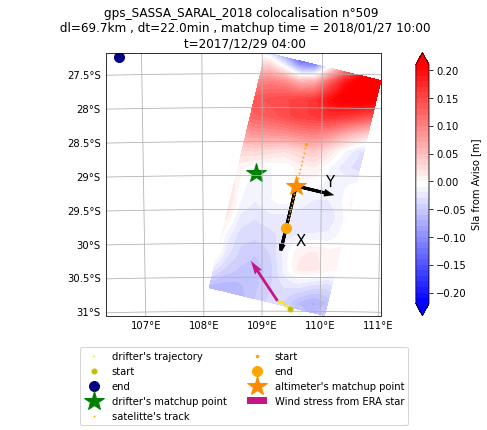

In [73]:
fig = plt.figure(figsize =(10,6))
t, td = coloc_image_t(fig,do,0,509,42)

In [23]:
t.day_of_year


361

In [74]:
def save_coloc_image(nlabel, nobs, dt=(-300,300), dt_d = (-31,33), figsize =(10,6), scaleera=1, do=1):
    label=labels[nlabel]
    # Directory
    directory = f"labels{nlabel}_iobs{nobs}"
    # Parent Directory path
    images_dir = "/home1/datahome/mdemol/m2_2022/images"
    # Path
    path = os.path.join(images_dir, directory)
    os.mkdir(path)
    
    #create dataset
    if isinstance(do, int):
        do=dataset_one_obs(nlabel, nobs, dt, dt_d)
    
    # boucle for sur les différents temps
    for time_indice in range(0,len(do.drifter_time.values), 12):    
        fig = plt.figure(figsize=figsize)
        fig.patch.set_facecolor('white')#no transparancy in png
        coloc_image_t(fig, do, nlabel, nobs, time_indice, scaleera)  
        fig.savefig(f"{path}/t_{time_indice}.png", dpi=250)
        plt.close(fig)


In [75]:
save_coloc_image(0,509, do=do)

# Creating GIF

In [76]:
nlabel=0
nobs=509
# Directory
directory = f"labels{nlabel}_iobs{nobs}"
# Parent Directory path
images_dir = "/home1/datahome/mdemol/m2_2022/images"
# Path
path = os.path.join(images_dir, directory)
import glob
from PIL import Image
def make_gif(frame_folder,duration = 200):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save(f'{frame_folder}.gif', format="GIF", append_images=frames,
               save_all=True, duration=duration, loop=0)

In [77]:
make_gif(path)

# See trajectory in the box, with arrows for acceleration + values ?

In [168]:
do

<xarray.Dataset>
Dimensions:                                (drifter_time: 1489, alti_time: 21,
                                            sassa_meas_ind_wv: 128,
                                            alti_time_mid: 20, box_y: 40,
                                            box_x: 80)
Coordinates: (12/21)
    alti_lat                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_lon                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                              (alti_time) int64 0 1 2 ... 18 19 20
    alti_time_                             (alti_time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * alti_time_mid                          (alti_time_mid) float64 0.5 ... 19.5
    alti_x                                 (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    ...                                     ...
    lat                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    time                                   datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    aviso_time_                            (drifter_time) datetime64[ns] 2017...
    es_time_                               (drifter_time) datetime64[ns] 2017...
  * drifter_time                           (drifter_time) datetime64[ns] 2017...
Dimensions without coordinates: sassa_meas_ind_wv
Data variables: (12/120)
    __site_id                              object dask.array<chunksize=(), meta=np.ndarray>
    __site_matchup_indice                  int32 dask.array<chunksize=(), meta=np.ndarray>
    __site_name                            object dask.array<chunksize=(), meta=np.ndarray>
    acc_x                                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    acc_y                                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    alti___distance                        float64 dask.array<chunksize=(), meta=np.ndarray>
    ...                                     ...
    es_cstrio_z0_drifter_wd_n              (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_traj_wd_e                 (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_traj_wd_n                 (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_box_wd_e                  (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    es_cstrio_z0_box_wd_n                  (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    drifter_typebuoy                       (drifter_time) object dask.array<chunksize=(94,), meta=np.ndarray>
Attributes:
    __id:                   PEACHI-L2-SLA-Sentinel-3_A__gps
    __time_coverage_end:    2018-09-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [171]:
do_box= do
#do_box = do_box.where(do_box.drifter_y>-100e3,drop=True)
#do_box = do_box.where(do_box.drifter_x<200e3, drop=True)
#do_box = do_box.where(do_box.drifter_y>-200e3, drop=True)
#do_box=do_box.where(do_box.drifter_x>-200e3)

In [170]:
do_box

<xarray.Dataset>
Dimensions:                                (drifter_time: 1489, alti_time: 21,
                                            sassa_meas_ind_wv: 128, box_y: 40,
                                            box_x: 80, alti_time_mid: 20)
Coordinates: (12/21)
    alti_lat                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_lon                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                              (alti_time) int64 0 1 2 ... 18 19 20
    alti_time_                             (alti_time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * alti_time_mid                          (alti_time_mid) float64 0.5 ... 19.5
    alti_x                                 (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    ...                                     ...
    lat                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    time                                   datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    aviso_time_                            (drifter_time) datetime64[ns] 2017...
    es_time_                               (drifter_time) datetime64[ns] 2017...
  * drifter_time                           (drifter_time) datetime64[ns] 2017...
Dimensions without coordinates: sassa_meas_ind_wv
Data variables: (12/120)
    __site_id                              (drifter_time) object dask.array<chunksize=(1489,), meta=np.ndarray>
    __site_matchup_indice                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    __site_name                            (drifter_time) object dask.array<chunksize=(1489,), meta=np.ndarray>
    acc_x                                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    acc_y                                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    alti___distance                        (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    ...                                     ...
    es_cstrio_z0_drifter_wd_n              (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_traj_wd_e                 (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_traj_wd_n                 (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_box_wd_e                  (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    es_cstrio_z0_box_wd_n                  (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    drifter_typebuoy                       (drifter_time) object dask.array<chunksize=(94,), meta=np.ndarray>
Attributes:
    __id:                   PEACHI-L2-SLA-Sentinel-3_A__gps
    __time_coverage_end:    2018-09-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

Text(0.5, 1.0, 'dl=81.8km , dt=20.2min , matchup time =2018/01/15 21:00\n t=2018/01/15 22:00')

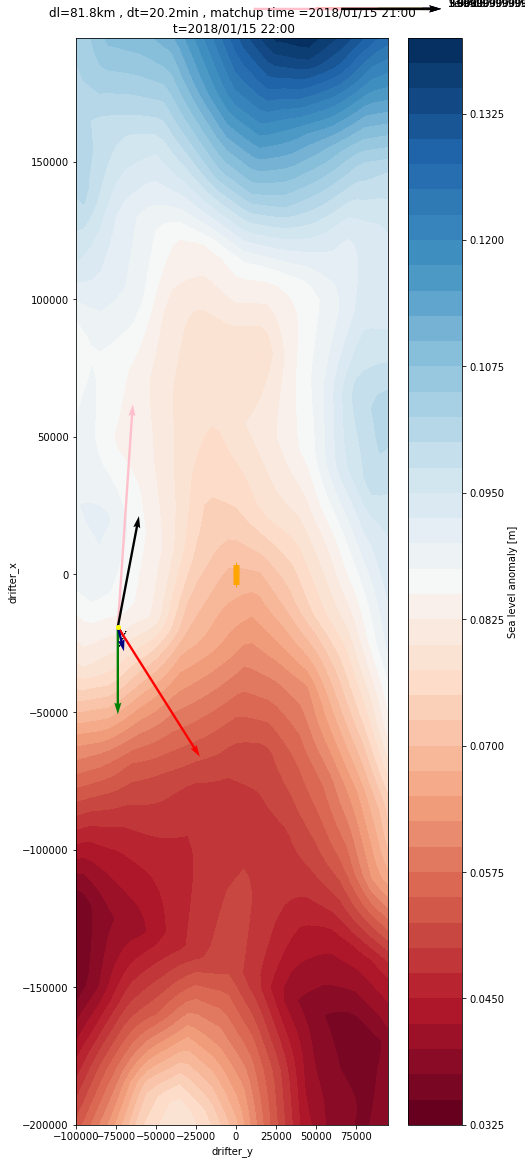

In [180]:
fig = plt.figure(figsize=(7,20))
it=777


lon, lat, t = float(do_box.lon), float(do_box.lat), do.time.values
id_matchup = int(do_box.__site_matchup_indice.values)
td = pd.to_datetime(t)
dt = float(do_box["alti___time_difference"])
dl = float(do_box["alti___distance"])
    
do_bt = do_box.isel(drifter_time = it)
do_bt['sum_x'] = do_bt['coriolis_x']+do_bt['es_cstrio_z0_drifter_wd_x']+do_bt['aviso_traj_g_grad_x']
do_bt['sum_y'] = do_bt['coriolis_y']+do_bt['es_cstrio_z0_drifter_wd_y']+do_bt['aviso_traj_g_grad_y']

t = pd.to_datetime(do_t.drifter_time.values)
ax = fig.add_subplot(111)

#AVISO
#ax.contourf( do_t.box_y, do_t.box_x, do_t.aviso_sla.transpose(), levels=30, cmap='viridis', label='aviso', zorder=1)
do_bt.aviso_box_sla.plot.contourf( x='box_y', y='box_x', levels=50, cmap='RdBu', label='aviso', zorder=1, ax=ax)

# drifter
ax.plot( do_box["drifter_y"][it-10:it+10], do_box["drifter_x"][it-10:it+10], color="k", ms=1, ls='', marker='+', label="drifter's trajectory", zorder=1)
#ax.plot( do["drifter_y"][0], do["drifter_x"][0], "b", ms=10, marker='x', color="k",  label='start', zorder=1)
#ax.plot( do["drifter_y"][-1], do["drifter_x"][-1], "b", ms=10, marker='x', color="k",  label='end', zorder=1)

ax.plot( do_bt["drifter_y"], do_bt["drifter_x"], color="yellow", marker = 'o', ms=4,  label="drifter's trajectory", zorder = 3)

#Satelite
ax.plot( do_bt["alti_y"], do_bt["alti_x"], color="orange", lw=1, ls='', marker='+', label="satelite trajectory")

#acceleration arrows - acc + coriolis + Ekman acceleration + gradient
do_bt.plot.quiver(x='drifter_y',y='drifter_x', u='acc_y', v='acc_x', color='r', pivot='tail', scale=5e-5)#, zorder = 3)
(-do_bt).plot.quiver(x='drifter_y',y='drifter_x', u='es_cstrio_z0_drifter_wd_y', v='es_cstrio_z0_drifter_wd_x', color='pink', pivot='tail', scale=5e-5)#, zorder = 3)
(-do_bt).plot.quiver(x='drifter_y',y='drifter_x', u='coriolis_y', v='coriolis_x', color='g', pivot='tail', scale=5e-5)#, zorder = 3)
(-do_bt).plot.quiver(x='drifter_y',y='drifter_x', u='aviso_traj_g_grad_y', v='aviso_traj_g_grad_x', color='navy', pivot='tail', scale=5e-5)#, zorder = 3)
(-do_bt).plot.quiver(x='drifter_y',y='drifter_x', u='sum_y', v='sum_x', color='k', pivot='tail', scale=5e-5)#, zorder = 3)

ax.set_title(f"dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , matchup time =" +td.strftime("%Y/%m/%d %H:%M") 
             +'\n t=' +t.strftime("%Y/%m/%d %H:%M"))


In [158]:
(do_bt['es_cstrio_z0_drifter_wd_x']).compute()

<xarray.DataArray 'es_cstrio_z0_drifter_wd_x' ()>
array(nan)
Coordinates:
    drifter_time  datetime64[ns] 2018-02-11T04:00:00
    drifter_lat   float64 44.46
    drifter_lon   float64 -160.8
    drifter_x     float64 1.415e+03
    drifter_y     float64 6.259e+04
    lat           float64 44.96
    lon           float64 -162.5
    time          datetime64[ns] 2018-01-15T21:00:00
    aviso_time_   datetime64[ns] 2018-02-11T04:00:00
    es_time_      datetime64[ns] 2018-02-11T04:00:00

In [22]:
-do_t

<xarray.Dataset>
Dimensions:                                (alti_time: 21,
                                            sassa_meas_ind_wv: 128,
                                            alti_time_mid: 20, box_y: 40,
                                            box_x: 80)
Coordinates: (12/21)
    alti_lat                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_lon                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                              (alti_time) int64 0 1 2 ... 18 19 20
    alti_time_                             (alti_time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * alti_time_mid                          (alti_time_mid) float64 0.5 ... 19.5
    alti_x                                 (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    ...                                     ...
    lat                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    time                                   datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    aviso_time_                            datetime64[ns] 2018-01-28T09:00:00
    es_time_                               datetime64[ns] 2018-01-28T09:00:00
    drifter_time                           datetime64[ns] 2018-01-28T09:00:00
Dimensions without coordinates: sassa_meas_ind_wv
Data variables: (12/108)
    __site_id                              object dask.array<chunksize=(), meta=np.ndarray>
    __site_matchup_indice                  int32 dask.array<chunksize=(), meta=np.ndarray>
    __site_name                            object dask.array<chunksize=(), meta=np.ndarray>
    acc_x                                  float64 dask.array<chunksize=(), meta=np.ndarray>
    acc_y                                  float64 dask.array<chunksize=(), meta=np.ndarray>
    alti___distance                        float64 dask.array<chunksize=(), meta=np.ndarray>
    ...                                     ...
    aviso_alti_matchup_g_grad_y            float64 -2.4e-06
    es_cstrio_z0_alti_wd_x                 float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_alti_wd_y                 float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_drifter_wd_x              float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_drifter_wd_y              float64 dask.array<chunksize=(), meta=np.ndarray>
    drifter_typebuoy                       object dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    __id:                   PEACHI-L2-SLA-Sentinel-3_A__gps
    __time_coverage_end:    2018-09-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [ ]:
#ax = fig.add_subplot(133)
#AVISO
#ax.contourf(do_t.box_x, do_t.box_y, do_t.aviso_sla, levels=30, cmap='viridis', label='aviso', zorder=1)
#

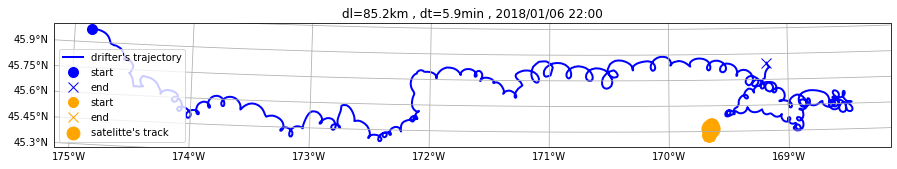

In [16]:

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection=ccrs.Orthographic(lon, lat))

land_feature = cfeature.LAND
#ax.add_feature(land_feature, zorder=2)

# aviso
#ax.contourf(do.box_lon, do.box_lat, slam, levels=30, cmap=cm.diff, transform=crs, label='aviso')
#ax.plot(_ds.box_lon[::10,::10], _ds.box_lat[::10,::10], "+", color="k", transform=crs)


# drifter
ax.plot(do["drifter_lon"], do["drifter_lat"], color="b", lw=2, transform=crs, label="drifter's trajectory")
ax.plot(do["drifter_lon"][0], do["drifter_lat"][0], "o", ms=10, color="b", transform=crs, label='start')
ax.plot(do["drifter_lon"][-1], do["drifter_lat"][-1], "x", ms=10, color="b", transform=crs, label='end')

#ax.plot(do["drifter_lon"], _dsm["drifter_lat"], 
#        "*", ms=20, color="g", lw=2, transform=crs, label='matchup point')

# altimetry
#ax.plot(_ds[asuff+"_lon"], _ds[asuff+"_lat"], color="orange", lw=2, transform=crs)
_sla = do["alti_sla"]
_sla = _sla - _sla.min()
ax.plot(do["alti_lon"][0], do["alti_lat"][0], "o", ms=10, color="orange", transform=crs, label='start')
ax.plot(do["alti_lon"][-1], do["alti_lat"][-1], "x", ms=10, color="orange", transform=crs,label='end')
ax.scatter(do["alti_lon"], do["alti_lat"], s=_sla*1000, color="orange", transform=crs, label= "satelitte's track")

gl = ax.gridlines(draw_labels=True, dms=False, 
             x_inline=False, y_inline=False, 
            )
gl.right_labels=False
gl.top_labels=False

ax.set_title(f"dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , "+td.strftime("%Y/%m/%d %H:%M"))
plt.legend()

In [70]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/m2env/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/mdemol/.miniconda3/envs/m2env/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/mdemol/.miniconda3/envs/m2env/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/